# Get my data

In [ ]:
import pickle
from google.colab import userdata, auth
from google.cloud import storage

In [ ]:
auth.authenticate_user()
google_client = storage.Client()


In [ ]:
#embedding_pickles = ["combined_embeddings/100_ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_embeddings.pickle",
                      # "combined_embeddings/100_ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_embedding.pickle",
                      # "combined_embeddings/100_ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData_embedding.pickle",
                      # "combined_embeddings/100_ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2_embedding.pickle",
                      # "combined_embeddings/100_BraTS-MEN-Train_embedding.pickle"]

embedding_pickles = {"GLI": "combined_embeddings/100_ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_embeddings.pickle",
                      "MET": "combined_embeddings/100_ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_embedding.pickle",
                       "MEN": "combined_embeddings/100_BraTS-MEN-Train_embedding.pickle"}

In [ ]:
# Initialize a dictionary to hold the data
data_files = {}

for key, entry in embedding_pickles.items():
    bucket = google_client.get_bucket("picture_embeddings")
    blob = bucket.get_blob(entry)
    raw_data = blob.download_as_bytes()
    data = pickle.loads(raw_data)
    data_files[f'data_{key}'] = data

In [ ]:
data[list(data.keys())[0]].keys()

dict_keys(['pat_id', 'bucket_url', 'origin_ds', 'diagnose', 'embeddings'])

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib.colors

def plot_tsne(model, mode):
    '''
    model can be resnet etc
    mode flair, seg_flair, etc
    '''

    # Prepare a list to hold data
    data = []

    # Iterate over each data category
    for category, patients in data_files.items():
        # Iterate over each patient
        for patient_id, patient_data in patients.items():
            emb_value = patient_data["embeddings"][model][mode]
            data.append({"pat_id": patient_id, mode: emb_value, "category": category})

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Convert to a list of lists of floats. If 'Flair' contains string representations of lists, use literal_eval
    # If 'Flair' already contains lists of floats, you can directly convert it to a numpy array without using apply(literal_eval)
    matrix = np.array(df[mode].apply(literal_eval).tolist()) if isinstance(df[mode].iloc[0], str) else np.array(df[mode].tolist())

    # Create a t-SNE model and transform the data
    tsne = TSNE(n_components=2, perplexity=20, random_state=42, init='random', learning_rate=200)
    vis_dims = tsne.fit_transform(matrix)

    # Assuming 'vis_dims' contains the t-SNE results and 'df' is your DataFrame

    # Map each unique category to a color
    unique_categories = df['category'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
    category_to_color = dict(zip(unique_categories, colors))

    # Extract coordinates for plotting
    x = [x for x, y in vis_dims]
    y = [y for x, y in vis_dims]

    # Map each data point's category to a color index
    color_indices = [category_to_color[category] for category in df['category']]

    # Scatter plot
    plt.scatter(x, y, c=color_indices, alpha=0.3)

    # Plot the average point for each category
    for category in unique_categories:
        avg_x = np.array(x)[df['category'] == category].mean()
        avg_y = np.array(y)[df['category'] == category].mean()
        plt.scatter(avg_x, avg_y, marker='x', color=category_to_color[category], s=100)

    # Optionally, you can add a legend to map colors to categories
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=category,
                                  markerfacecolor=color, markersize=10) for category, color in category_to_color.items()],
              title="Categories")

    plt.show()


# Different visualizations

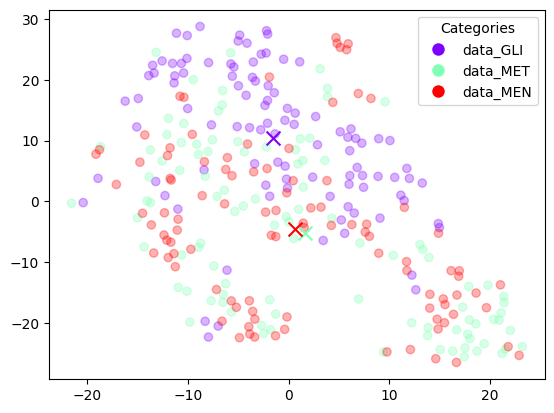

In [ ]:
plot_tsne("RESNET152_IMAGENET", "flair")

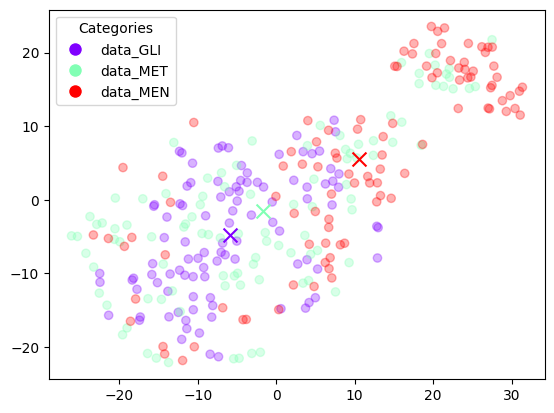

In [ ]:
plot_tsne("RESNET152_IMAGENET", "seg_flair")

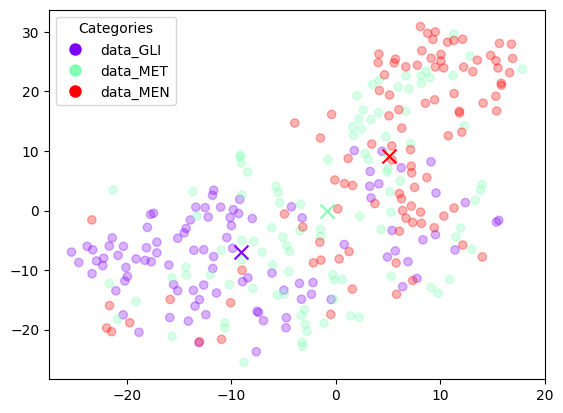

In [ ]:
plot_tsne("RESNET152_IMAGENET", "seg_t1c")

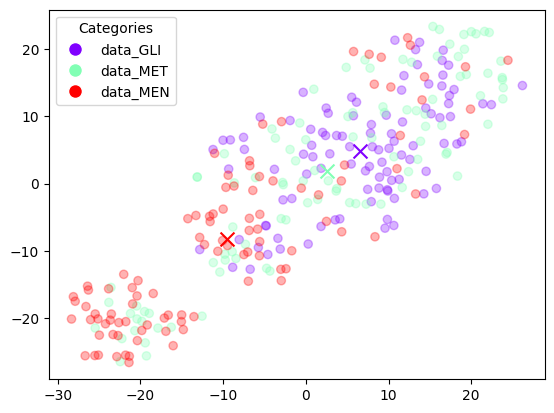

In [ ]:
plot_tsne("RESNET152_IMAGENET", "seg_t2")

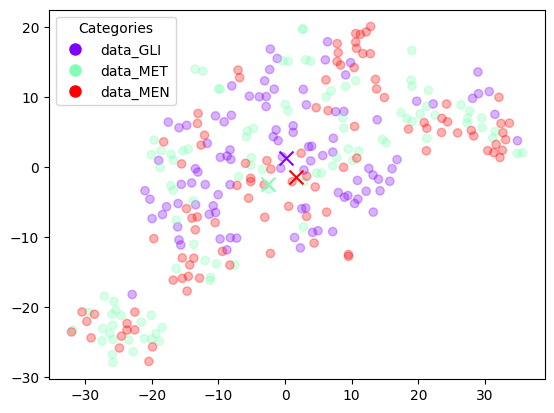

In [ ]:
plot_tsne("RESNET152_IMAGENET", "t2")

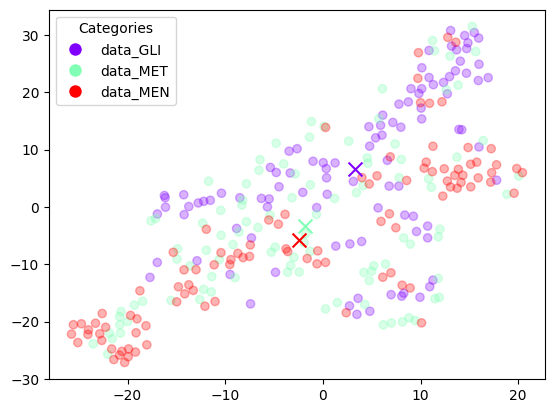

In [ ]:
plot_tsne("RESNET50_MEDCLIP", "seg_t1c")